In [ ]:
library('dplyr')
library(plyr)
library(ggplot2)
#library(ImpulseDE2.extended)

library(Biobase)
library(BiocParallel)
library(circlize)
import::from(compiler, cmpfun)
library(ComplexHeatmap)
import::from(cowplot, plot_grid)
library(DESeq2)
library(ggplot2)
import::from(grDevices, dev.off, graphics.off, pdf)
library(knitr)
library(Matrix)
library(methods)
import::from(stats, dnbinom, median, optim, p.adjust, pchisq, rnbinom, rnorm, runif, sd, time)
library(SummarizedExperiment)
import::from(utils, packageDescription)
import::from(zoo,as.zoo,rollapply)

sapply(list.files('/home/khrovatin/git/ImpulseDE2_extended/R', full.name=TRUE), source)

In [159]:
server=TRUE
if (server){
    pathSave='/home/khrovatin/timeTrajectoriesNet/data/stages/disagg/impulse/'
    pathCounts='/home/khrovatin/timeTrajectoriesNet/data/counts/'
    pathConditions='/home/khrovatin/timeTrajectoriesNet/data/RPKUM/'
}else{
    pathSave='/home/karin/Documents/timeTrajectories/data/stages/disagg/impulse/'
    pathCounts='/home/karin/Documents/timeTrajectories/data/countsRaw/combined/'
    pathConditions='/home/karin/Documents/timeTrajectories/data/RPKUM/combined/'
}

In [160]:
genes<-read.table(paste(pathCounts,'mergedGenes_counts.tsv',sep=''), header=TRUE,row.names=1, sep="\t")
conditions<-read.table(paste(pathConditions,'conditions_mergedGenes.tsv',sep=''), header=TRUE,row.names='Measurment', sep="\t")
conditions[conditions=='']=NA
#R imported colnames of genes with changes but gene IDs remained ok
rownames(conditions)<-make.names(rownames(conditions))

In [130]:
Y=conditions[conditions$Group=='WT', 'Time',drop=F]
Y[,'Sample']=rownames(Y)
Y[,'Condition']='case'

# Retain only times with more than 2 samples - AX4 has some reps 
# that have more time points and can affect model fitting
minNRep=2
sampleCount<-count(Y,'Time')
Y<- Y[Y$Time %in% sampleCount[sampleCount$freq>minNRep,'Time'],]

Y<-Y[order(Y$Time),]
X=genes[,Y$Sample]
print(dim(X))

[1] 12828    98


In [131]:
objectImpulseDE2 <- runImpulseDE2(matCountData = as.matrix(X), dfAnnotation = Y,boolCaseCtrl = FALSE,
                                  vecConfounders = NULL,
                                  boolIdentifyTransients = TRUE,scaNProc = 40, boolExtended=TRUE)

saveRDS(object=objectImpulseDE2,file=paste(pathSave,'WT_min',minNRep,'Rep.rds',sep=''))

ImpulseDE2 for count data, v1.10.0

# Process input



Processing Details:
ImpulseDE2 runs in case-only mode.
Found time points: 0,1,2,3,4,5,6,8,12,16,20,24
Case: Found the samples at time point 0: FDpool01_TCGCAGG_Hr00_mappedGene_expressions_All_milestone_mRNA_gff,FDpool02_TCGCAGG_Hr00_mappedGene_expressions_All_milestone_mRNA_gff,Ax4_r1_00h_9_S86_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff,Ax4_r2_00h_9_S58_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff,Pool26_AX4_bio2_hr00_1_TCGCAGG_mappedGene_expressions_All_milestone_mRNA_gff,pool27_AX4_bio1_hr00_1_TCGCAGG_mappedGene_expressions_All_milestone_mRNA_gff,Pool28_AX4_bio2_hr00_1_13_ACTATCA_mappedGene_expressions_All_milestone_mRNA_gff,pool30_MybBGFP_bio1_hr00_1_TCGCAGG_mappedGene_expressions_All_milestone_mRNA_gff,Pool28_MybBGFP_bio2_hr00_1_TCGCAGG_mappedGene_expressions_All_milestone_mRNA_gff
Case: Found the samples at time point 1: FDpool01_CTCTGCA_Hr01_mappedGene_expressions_All_milestone_mRNA_gff,FDpool02_CTCTGCA_Hr01_mappedGene_expressions_All_milestone_mRNA_gf

# Run DESeq2: Using dispersion factorscomputed by DESeq2.

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



[1] "Corrected 20 DESEq2 dispersion estimates which to avoid variance overestimation and loss of discriminatory power for model selection."


Consumed time: 0.28 min.

# Compute size factors

# Fitting null and alternative model to the genes

Consumed time: 1.33 min.

# Fitting sigmoid model to case condition

Consumed time: 0.7 min.

# Fitting 3 and 4 sigmoid model to case condition

[1] "ERROR: Fitting four sigmoid model: fitFourSigmoidModel() with optimisation method BFGS from a list of possible optimisation methods BFGS, Nelder-Mead, SANN. Wrote report into ImpulseDE2_lsErrorCausingGene.RData"
[1] "vecParamGuess 1, 4.73096140795991, 4.30082512498217, 6.21204561958178, 5.46665442356036, 5.2890203779299, 0.5, 10, 18, 22"
[1] "vecCounts 307, 32, 15, 34, 37, 22, 120, 180, 140, 40, 20, 9, 11, 55, 165, 104, 154, 122, 11, 19, 158, 283, 131, 209, 55, 34, 15, 216, 179, 199, 181, 53, 63, 90, 38, 35, 56, 384, 177, 95, 92, 42, 8, 103, 522, 215, 87, 274, 27, 43, 165, 2029, 548, 323, 83, 61, 58, 41, 37, 325, 1128, 437, 1150, 1013, 353, 456, 74, 34, 540, 485, 1694, 1069, 949, 251, 261, 55, 287, 469, 495, 729, 263, 118, 93, 125, 47, 72,

[1] "ERROR: Fitting three sigmoid model: fitThreeSigmoidModel() with optimisation methodBFGSfrom a list of possible optimisation methods BFGS, Nelder-Mead, SANN.Wrote report into ImpulseDE2_lsErrorCausingGene.RData"
[1] "vecParamGuess 1, 0.987362617947808, 0.733696405458344, 4.820601148507, 5.38046571496227, 0.5, 10, 18"
[1] "vecCounts 3, 1, 4, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 2, 1, 2, 1, 1, 1, 2, 0, 2, 3, 0, 0, 1, 1, 1, 3, 2, 0, 5, 0, 0, 1, 0, 0, 2, 0, 0, 3, 0, 1, 1, 5, 2, 1, 4, 4, 2, 8, 88, 6, 49, 9, 36, 24, 30, 65, 52, 136, 21, 149, 132, 217, 139, 102, 175, 148, 44, 236, 190, 118, 131, 52, 41, 155, 169, 72, 156, 226, 203, 160, 113, 126, 174, 141, 46, 135, 175, 153, 381, 174, 94, 143, 161, 65, 100"
[1] "scaDisp 4.37157143430253"
[1] "vecSizeFactors 0.701485255754495, 0.594400028683807, 0.645034358113565, 0.80265963825788, 0.903408794016143, 0.994543530138228, 2.08626715451674, 0.88597644629937, 1.07044202856428, 0.394687644813577, 0.442892550469752, 0.378008665756121, 0.759736794141506,

[1] "ERROR: Fitting three sigmoid model: fitThreeSigmoidModel() with optimisation methodBFGSfrom a list of possible optimisation methods BFGS, Nelder-Mead, SANN.Wrote report into ImpulseDE2_lsErrorCausingGene.RData"
[1] "vecParamGuess 1, 3.1084023082402, 3.99727884102495, 5.59674813136738, 5.58573130116414, 0.5, 4.5, 18"
[1] "vecCounts 5, 2, 4, 23, 5, 6, 24, 47, 76, 14, 1, 13, 12, 37, 71, 245, 14, 32, 15, 19, 83, 88, 535, 22, 36, 18, 36, 83, 129, 473, 29, 28, 46, 50, 58, 73, 101, 172, 367, 28, 138, 135, 253, 657, 245, 516, 144, 28, 178, 254, 657, 1190, 506, 468, 40, 352, 294, 199, 304, 572, 1312, 520, 381, 288, 359, 201, 172, 252, 440, 255, 541, 247, 211, 185, 125, 62, 248, 369, 289, 532, 226, 146, 151, 173, 108, 190, 335, 202, 312, 226, 139, 223, 130, 84, 281, 353, 177, 216"
[1] "scaDisp 2.34898333209901"
[1] "vecSizeFactors 0.701485255754495, 0.594400028683807, 0.645034358113565, 0.80265963825788, 0.903408794016143, 0.994543530138228, 2.08626715451674, 0.88597644629937, 1.07044202856

Consumed time: 8.68 min.

# Differentially expression analysis based on model fits

Finished running ImpulseDE2.

TOTAL consumed time: 11.43 min.



In [133]:
r<-objectImpulseDE2$dfImpulseDE2Results
r<-r[!r$allZero,]

In [134]:
r[plotGenes[36],]

,Gene,p,padj,loglik_full,loglik_red,df_full,df_red,mean,converge_impulse,converge_const,⋯,fourSigmoidTOsigmoid_p,fourSigmoidTOsigmoid_padj,fourSigmoidTOimpulse_p,fourSigmoidTOimpulse_padj,fourSigmoidTOthreeSigmoid_p,fourSigmoidTOthreeSigmoid_padj,NMinMax_impulse,NMinMax_threeSigmoid,NMinMax_fourSigmoid,allZero
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
DDB_G0293460,DDB_G0293460,3.754861e-93,5.870417e-92,-698.4614,-919.0956,7,2,315.1789,0,0,⋯,2.516553e-09,2.805229e-08,1.828301e-83,1.315929e-82,8.202073e-07,1.418821e-05,2,3,4,FALSE


In [140]:
plots2<-plotGenesExtended(
vecGeneIDs = plotGenes,
scaNTopIDs = NULL,
objectImpulseDE2 = objectImpulseDE2,
boolCaseCtrl = FALSE,
dirOut = NULL,
strFileName = NULL,
vecRefPval = NULL,
strNameRefMethod = NULL,model='threeSigmoid')

[1] "Setting boolSimplePlot=TRUE as no batch structure was found."


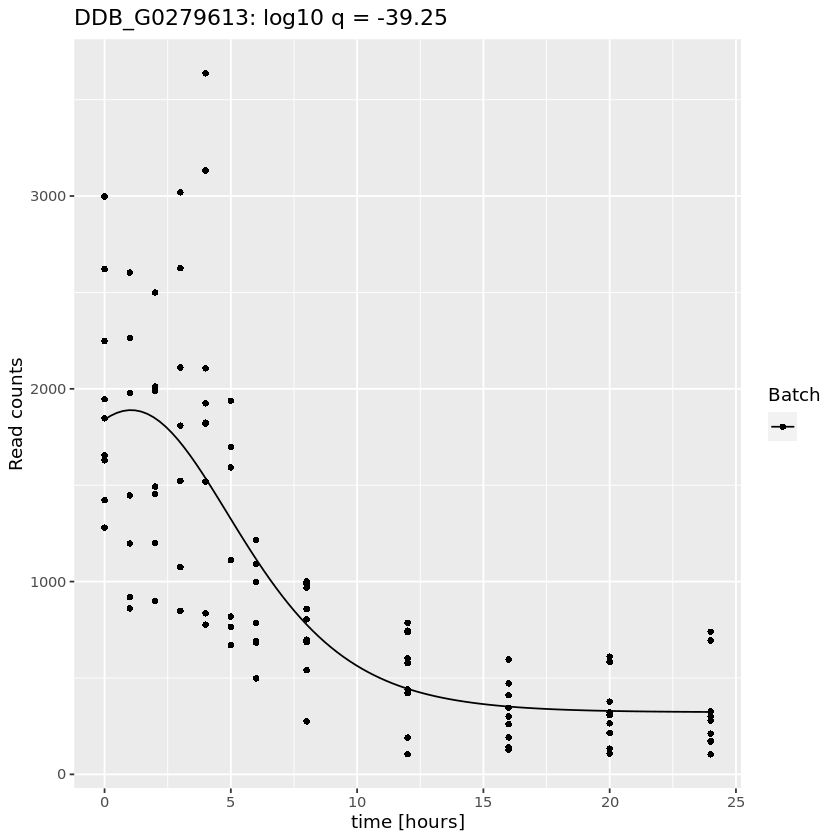

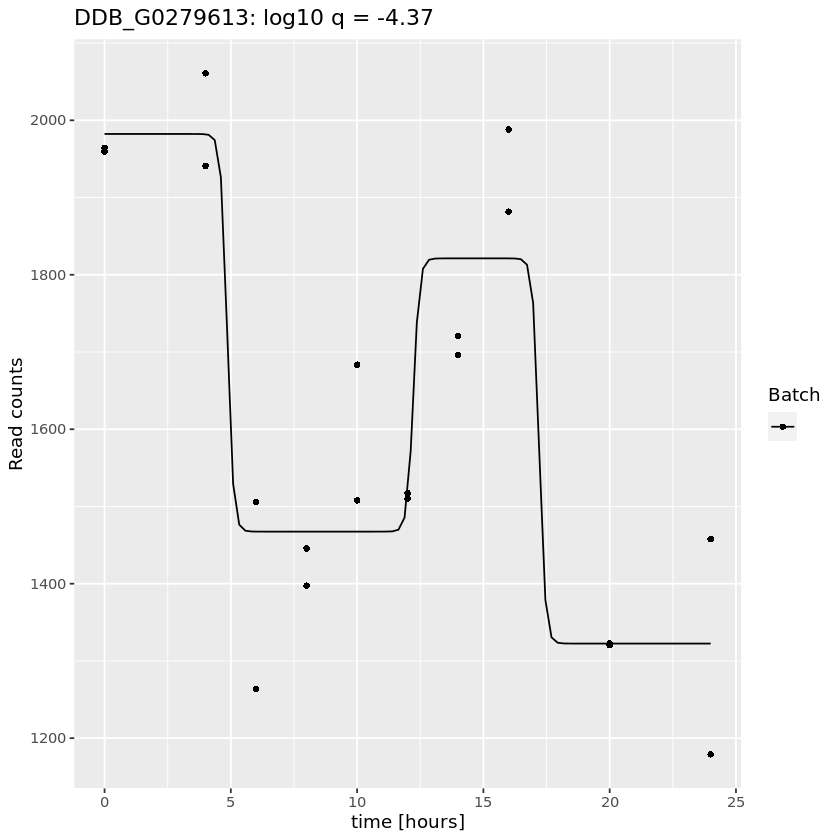

In [157]:
idx=16
plots2[[idx]]
plots[[idx]]

In [78]:
plotGenes<-r[r$threeSigmoidTOimpulse_padj<=0.01 & 
             r$threeSigmoidTOsigmoid_padj<=0.01 &
             r$threeSigmoidTOconst_padj<=0.01
             & r$NMinMax_threeSigmoid==4  ,'Gene']

In [79]:
length(plotGenes)

[1] 36

In [94]:
plots <- plotGenesExtended(
vecGeneIDs = plotGenes,
scaNTopIDs = NULL,
objectImpulseDE2 = objectImpulseDE2,
boolCaseCtrl = FALSE,
dirOut = NULL,
strFileName = NULL,
vecRefPval = NULL,
strNameRefMethod = NULL,model='threeSigmoid')

[1] "Setting boolSimplePlot=TRUE as no batch structure was found."


In [132]:
plotGenes[36]

[1] "DDB_G0293460"

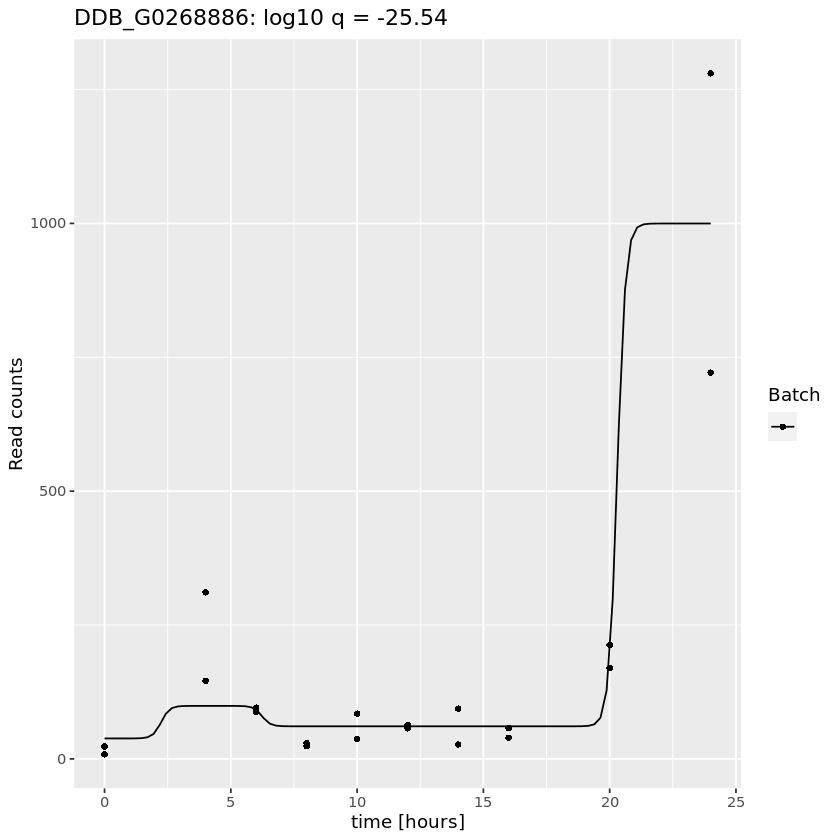

In [138]:
plots[[2]]

In [47]:
for(strain in c('tgrB1','tgrB1C1','tgrC1','gbfA')[4]){
    print(strain)
    Y=conditions[conditions$Strain==strain, c('Time','Replicate'),drop=F]
    colnames(Y)<-c('Time','Batch')
    Y[,'Sample']=rownames(Y)
    Y[,'Condition']='case'
    Y<-Y[order(Y$Time),]
    X=genes[,Y$Sample]
    print(dim(Y))
    objectImpulseDE2 <- runImpulseDE2(matCountData = as.matrix(X), dfAnnotation = Y,boolCaseCtrl = FALSE,
                                  #vecConfounders = c('Batch'),
                                      vecConfounders = NULL,
                                  boolIdentifyTransients = TRUE,scaNProc = 40, boolExtended=TRUE)

    saveRDS(object=objectImpulseDE2,file=paste(pathSave,strain,'.rds',sep=''))
}

[1] "gbfA"
[1] 20  4


ImpulseDE2 for count data, v1.10.0

# Process input



Processing Details:
ImpulseDE2 runs in case-only mode.
Found time points: 0,4,6,8,10,12,14,16,20,24
Case: Found the samples at time point 0: gbfA_0h_r1_28_S79_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff,gbfA_r3_00h_1_S126_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff
Case: Found the samples at time point 4: gbfA_4h_r1_29_S80_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff,gbfA_r3_04h_2_S127_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff
Case: Found the samples at time point 6: gbfA_6h_r1_30_S81_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff,gbfA_r3_06h_3_S128_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff
Case: Found the samples at time point 8: gbfA_8h_r1_31_S82_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff,gbfA_r3_08h_4_S129_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff
Case: Found the samples at time point 10: gbfA_10h_r1_32_S83_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff,gbfA_

# Run DESeq2: Using dispersion factorscomputed by DESeq2.

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



[1] "Corrected 17 DESEq2 dispersion estimates which to avoid variance overestimation and loss of discriminatory power for model selection."


Consumed time: 0.11 min.

# Compute size factors

# Fitting null and alternative model to the genes

Consumed time: 1 min.

# Fitting sigmoid model to case condition

Consumed time: 0.57 min.

# Fitting 3 and 4 sigmoid model to case condition

[1] "ERROR: Fitting three sigmoid model: fitThreeSigmoidModel() with optimisation methodBFGSfrom a list of possible optimisation methods BFGS, Nelder-Mead, SANN.Wrote report into ImpulseDE2_lsErrorCausingGene.RData"
[1] "vecParamGuess 1, 2.72776619196003, 4.28408049625794, 6.58281984614521, 6.56402155508148, 5, 13, 18"
[1] "vecCounts 7, 15, 131, 294, 64, 72, 219, 264, 247, 794, 256, 875, 271, 1751, 665, 670, 224, 1021, 560, 339"
[1] "scaDisp 8.01156449089719"
[1] "vecSizeFactors 0.47411294091986, 1.08436861344053, 0.658986872473096, 1.50474719706407, 0.720192904736717, 1.32825256287335, 0.789938654219675, 1.25508063903975, 0.722272962919917, 2.04130324288277, 0.775042774296559, 2.55399435801507, 0.799944547976789, 2.16580901821569, 0.913424626645

In [162]:
impulse_WT<-readRDS(file=paste(pathSave,'WT_min2Rep','.rds',sep=''))
impulse_gbfA<-readRDS(file=paste(pathSave,'gbfA','.rds',sep=''))

In [734]:
bestFits<-function(objectImpulseDE2,scaQThres=0.001){
    result<-objectImpulseDE2$dfImpulseDE2Results
    result<-result[!result$allZero,]
    
    # P values for the model
    isSignifSigmoid<-result$sigmoidTOconst_padj<=scaQThres
    isSignifImpulse<-(result$padj<=scaQThres & 
                  result$impulseTOsigmoid_padj<=scaQThres) 
    isSignifThreeSigmoid<-(result$threeSigmoidTOconst_padj<=scaQThres & 
                       result$threeSigmoidTOsigmoid_padj<=scaQThres &
                       result$threeSigmoidTOimpulse_padj<=scaQThres)
    isSignifFourSigmoid<-(result$fourSigmoidTOconst_padj<=scaQThres & 
                      result$fourSigmoidTOsigmoid_padj<=scaQThres &
                      result$fourSigmoidTOimpulse_padj<=scaQThres &
                      result$fourSigmoidTOthreeSigmoid_padj<=scaQThres)  
    
    # May be this model due to pvalues and shape (local min/max count)
    boolSigmoid<-(isSignifSigmoid |
                 (isSignifImpulse & result$NMinMax_impulse ==2) |
                 (isSignifThreeSigmoid & result$NMinMax_threeSigmoid ==2) |
                 (isSignifFourSigmoid & result$NMinMax_fourSigmoid ==2))
    boolImpulse<-((isSignifImpulse & result$NMinMax_impulse == 3) |
                 (isSignifThreeSigmoid & result$NMinMax_threeSigmoid ==3) |
                 (isSignifFourSigmoid & result$NMinMax_fourSigmoid ==3))
    boolThreeSigmoid<-((isSignifThreeSigmoid & result$NMinMax_threeSigmoid == 4) |
                      (isSignifFourSigmoid & result$NMinMax_fourSigmoid == 4))
    boolFourSigmoid<-(isSignifFourSigmoid & result$NMinMax_fourSigmoid == 5)
    
    # Assign most complex model that is better fitted than less compelx models
    boolModels<-data.frame('S1'=boolSigmoid,'S2'=boolImpulse,'S3'=boolThreeSigmoid,'S4'=boolFourSigmoid)
    rownames(boolModels)<-rownames(result)
    boolModels['main']<-apply(boolModels, 1,function(x){
                                trueModels<-which(as.vector(unlist(x)))
                                if(length(trueModels)>0){
                                    model=max(trueModels)
                                }else{
                                    model=0
                                }
                                return(model)
                                })
    # Best fit is largest still significant model (better than less complex models)
    boolModels['bestFit']<-as.vector(unlist(lapply(1:dim(boolModels)[1],function(idx){
        bestFit=0
        if(isSignifFourSigmoid[idx] & result$NMinMax_fourSigmoid[idx] == (boolModels[idx,'main']+1)){
            bestFit=4
        }else if(isSignifThreeSigmoid[idx] & result$NMinMax_threeSigmoid[idx] == (boolModels[idx,'main']+1)){
            bestFit=3
        }else if(isSignifImpulse[idx] & result$NMinMax_impulse[idx] == (boolModels[idx,'main']+1)){
            bestFit=2
        }else if(isSignifSigmoid[idx]){
            bestFit=1
        }
        return(bestFit)
    })))

    return(boolModels)
}

In [ ]:
data

In [1111]:
#TODO - more transitions after first ref transition in case than ref
filterByTransitions<-function(impulse1,impulse2,fits1,fits2, vecGeneIDs){
    selected<-data.frame(row.names=vecGeneIDs)
    selected['selected']<-as.vector(unlist(lapply(vecGeneIDs, function(gene) {
        data1<-findTransitionsPeaks(impulse1,fits1[gene,'bestFit'],gene)
        data2<-findTransitionsPeaks(impulse2,fits2[gene,'bestFit'],gene)
        firstTransition1<-min(data1$transitions)
        boolLateTransition<-sum(data1$transitions>firstTransition1)<sum(data2$transitions>firstTransition1)
        # First min or max
        if(min(data1$timesMin)<min(data1$timesMax)){
            start='timesMin'
        }else{
            start='timesMax'
        }
        data2StartTime=min(data2[[start]])
        data2MinMax<-union(data2$timesMin[data2$timesMin>=data2StartTime],
                           data2$timesMax[data2$timesMax>=data2StartTime])
        data1MinMax<-union(data1$timesMin,data1$timesMax)
        boolComplexShape<-length(data2MinMax)>length(data1MinMax)
        return(boolLateTransition & boolComplexShape)
        #return(boolComplexShape)
    })))
    return(selected)
}

In [1114]:
res<-filterByTransitions(impulse_WT,impulse_gbfA,fits_WT,fits_gbfA,vecPlotGenes)

In [1059]:
r[!r$selected,]

logical(0)

In [1034]:
t(as.data.frame(lapply(1:3, function(x) return(c(FALSE,TRUE)))))

c.FALSE..TRUE.,FALSE,TRUE
c.FALSE..TRUE..1,FALSE,TRUE
c.FALSE..TRUE..2,FALSE,TRUE


In [1049]:
findTransitionsPeaks<-function(impulse,model,gene){
    modelExtraction<-vector('list',4)
    modelExtraction[[1]]<-vector('list',3)
    modelExtraction[[1]][[1]]<-c('lsSigmoidFit')
    modelExtraction[[1]][[2]]<-c('vecSigmoidParam')
    modelExtraction[[1]][[3]]<-c('t')
    modelExtraction[[2]]<-vector('list',3)
    modelExtraction[[2]][[1]]<-c('lsImpulseFit')
    modelExtraction[[2]][[2]]<-c('vecImpulseParam')
    modelExtraction[[2]][[3]]<-c('t1','t2')
    modelExtraction[[3]]<-vector('list',3)
    modelExtraction[[3]][[1]]<-c('lsThreeSigmoidFit')
    modelExtraction[[3]][[2]]<-c('vecThreeSigmoidParam')
    modelExtraction[[3]][[3]]<-c('t1','t2','t3')
    modelExtraction[[4]]<-vector('list',3)
    modelExtraction[[4]][[1]]<-c('lsFourSigmoidFit')
    modelExtraction[[4]][[2]]<-c('vecFourSigmoidParam')
    modelExtraction[[4]][[3]]<-c('t1','t2','t3','t4')
    transitionTimes<-as.vector(unlist(impulse@lsModelFits$case[[gene]]
                            [[modelExtraction[[model]][[1]]]][[modelExtraction[[model]][[2]]]]
                            [modelExtraction[[model]][[3]]]))
    vecTimePointsCase <- sort(
      get_lsModelFits(obj = impulse)$IdxGroups$case$vecTimepointsUnique,decreasing = FALSE)

    
     fit<-get_lsModelFits(obj = impulse)$case[[gene]]
     if (model == 1) {
        vecValues <- evalSigmoid_comp(
          vecSigmoidParam = fit$lsSigmoidFit$vecSigmoidParam,
          vecTimepoints = vecTimePointsCase)
      }else if (model == 2) {
        vecValues <- evalImpulse_comp(
          vecImpulseParam = fit$lsImpulseFit$vecImpulseParam,
          vecTimepoints = vecTimePointsCase)
      }else if (model == 3) {
        vecValues <- evalThreeSigmoid_comp(
          vecThreeSigmoidParam = fit$lsThreeSigmoidFit$vecThreeSigmoidParam,
          vecTimepoints = vecTimePointsCase)
      } else if (model == 4) {
        vecValues <- evalFourSigmoid_comp(
          vecFourSigmoidParam = fit$lsFourSigmoidFit$vecFourSigmoidParam,
          vecTimepoints = vecTimePointsCase)
      }
      vecValues<-as.vector(as.integer(vecValues))
      vecValuesUnique<-vecValues[vecValues!=c(vecValues[-1], FALSE)]
      vecTimePointsValues<-vecTimePointsCase[vecValues!=c(vecValues[-1], FALSE)]
      if(length(vecValuesUnique)>1){
        left<-vecValuesUnique[2]
        right<-tail(vecValuesUnique,2)[1]
        vecValuesUnique <- c(left, vecValuesUnique, right)
        vecValuesUnique <- as.zoo(vecValuesUnique)
        boolMin<-rollapply(vecValuesUnique, 3, function(x) which.min(x) == 2 )
        boolMax<-rollapply(vecValuesUnique, 3, function(x)  which.max(x) == 2)
        #Rollaply here does not give result for border elements
        timesMinMax<-vecTimePointsValues[boolMin|boolMax]   
        transitions<-c()                 
        for(idx in 2:length(timesMinMax)){
            t1=timesMinMax[idx-1]
            t2=timesMinMax[idx]
            #So that t outside of times range are included
            if(idx==2) t1=-Inf
            if(idx==length(timesMinMax)) t2=Inf
            transition<-mean(transitionTimes[transitionTimes > t1 & transitionTimes < t2])
            #Quick fix if transition times in not between min/max
            #TODO remove quick fix
            if(is.nan(transition)) transition=mean(c(timesMinMax[idx-1],timesMinMax[idx]))
            transitions<-c(transitions,transition)
        }                
      }else{
          transitions=NULL
      }
                          
    return(list(transitions=transitions,
                timesMin=vecTimePointsValues[boolMin],timesMax=vecTimePointsValues[boolMax]))
}

In [871]:
fits_WT<-bestFits(impulse_WT,0.01)
fits_gbfA<-bestFits(impulse_gbfA,0.01)
bothGenes<-intersect(rownames(fits_WT[fits_WT$main>0,]),rownames(fits_gbfA[fits_gbfA$main>0 ,]))
vecPlotGenes<-bothGenes[fits_WT[bothGenes,]$main<fits_gbfA[bothGenes,]$main]

In [394]:
result_WT<-impulse_WT$dfImpulseDE2Results
result_WT<-result_WT[!result_WT$allZero,]
result_gbfA<-impulse_gbfA$dfImpulseDE2Results
result_gbfA<-result_gbfA[!result_gbfA$allZero,]

In [898]:
unlist(result_WT[vecPlotGenes[idx],])
unlist(result_gbfA[vecPlotGenes[idx],])

Gene                              p 
                "DDB_G0267688"        "1.29387621412603e-151" 
                          padj                    loglik_full 
         "5.025366390148e-150"            "-574.460677085595" 
                    loglik_red                        df_full 
           "-930.425158093118"                            "7" 
                        df_red                           mean 
                           "2"             "389.664475470119" 
              converge_impulse                 converge_const 
                           "0"                            "0" 
              converge_sigmoid             impulseTOsigmoid_p 
                           "0"         "1.74302449163858e-09" 
         impulseTOsigmoid_padj               sigmoidTOconst_p 
         "6.3692590225527e-08"        "3.02987868289786e-145" 
           sigmoidTOconst_padj                    isTransient 
       "6.54231321896355e-144"                         "TRUE" 
                  isMonotonous          converge_threeSigmoid 
                       "FALSE"                            "0" 
          converge_fourSigmoid          threeSigmoidTOconst_p 
                           "0"        "4.34154912804148e-145" 
      threeSigmoidTOconst_padj        threeSigmoidTOsigmoid_p 
       "9.57544165722149e-144"         "0.000485571582109449" 
    threeSigmoidTOsigmoid_padj        threeSigmoidTOimpulse_p 
         "0.00202954132339553"                            "1" 
    threeSigmoidTOimpulse_padj           fourSigmoidTOconst_p 
                           "1"        "1.89224502202308e-155" 
       fourSigmoidTOconst_padj         fourSigmoidTOsigmoid_p 
          "6.58341359634e-154"         "1.15911525487246e-14" 
     fourSigmoidTOsigmoid_padj         fourSigmoidTOimpulse_p 
        "2.75312163710188e-13"         "1.64730121223822e-07" 
     fourSigmoidTOimpulse_padj    fourSigmoidTOthreeSigmoid_p 
        "4.70858997277348e-07"         "3.32894168246341e-13" 
fourSigmoidTOthreeSigmoid_padj                NMinMax_impulse 
        "1.45599551900099e-11"                            "3" 
          NMinMax_threeSigmoid            NMinMax_fourSigmoid 
                           "2"                            "3" 
                       allZero 
                       "FALSE"

Gene                              p 
                "DDB_G0267688"           "0.0947796889202511" 
                          padj                    loglik_full 
           "0.438269450343816"            "-131.463365730131" 
                    loglik_red                        df_full 
           "-136.154138445196"                            "7" 
                        df_red                           mean 
                           "2"             "246.752135360592" 
              converge_impulse                 converge_const 
                           "0"                            "0" 
              converge_sigmoid             impulseTOsigmoid_p 
                           "0"            "0.850409349830414" 
         impulseTOsigmoid_padj               sigmoidTOconst_p 
                           "1"           "0.0285364631967223" 
           sigmoidTOconst_padj                    isTransient 
          "0.0835104944765678"                        "FALSE" 
                  isMonotonous          converge_threeSigmoid 
                       "FALSE"                            "0" 
          converge_fourSigmoid          threeSigmoidTOconst_p 
                           "0"         "2.99640743886968e-05" 
      threeSigmoidTOconst_padj        threeSigmoidTOsigmoid_p 
        "0.000289476081996269"         "9.37036815380508e-05" 
    threeSigmoidTOsigmoid_padj        threeSigmoidTOimpulse_p 
         "0.00687274075296264"          "8.5902592810422e-06" 
    threeSigmoidTOimpulse_padj           fourSigmoidTOconst_p 
        "3.21512725131003e-05"          "1.5222027764531e-09" 
       fourSigmoidTOconst_padj         fourSigmoidTOsigmoid_p 
        "3.65876659348267e-08"         "3.47192104401592e-09" 
     fourSigmoidTOsigmoid_padj         fourSigmoidTOimpulse_p 
        "1.01769627090203e-06"         "3.07782984525504e-10" 
     fourSigmoidTOimpulse_padj    fourSigmoidTOthreeSigmoid_p 
        "1.26372938436198e-09"         "1.36930279674104e-06" 
fourSigmoidTOthreeSigmoid_padj                NMinMax_impulse 
        "0.000609491889304957"                            "3" 
          NMinMax_threeSigmoid            NMinMax_fourSigmoid 
                           "3"                            "4" 
                       allZero 
                       "FALSE"

In [755]:
impulse_WT@lsModelFits$case[['DDB_G0267382']][[modelExtraction[[4]][1]]][[modelExtraction[[4]][2]]]
impulse_gbfA@lsModelFits$case[[plotGenes[idx]]][[modelExtraction[[3]][1]]][[modelExtraction[[3]][2]]]

beta           h0           h1           h2           h3           h4 
2.923103e+00 1.019656e+03 2.342669e+04 3.316509e+04 1.446623e+04 8.128093e+03 
          t1           t2           t3           t4 
3.143891e-01 3.122086e-01 6.331168e+00 8.655668e+00

beta           h0           h1           h2           h3           t1 
  6.12249749   0.01200027  60.83255954  22.69206866 961.65411712   2.23924639 
          t2           t3 
  6.23416940  20.29800463

In [1001]:
which(vecPlotGenes=='DDB_G0282833')

[1] 53

[1]  6 24

In [1068]:
boolComplexShape

[1] FALSE

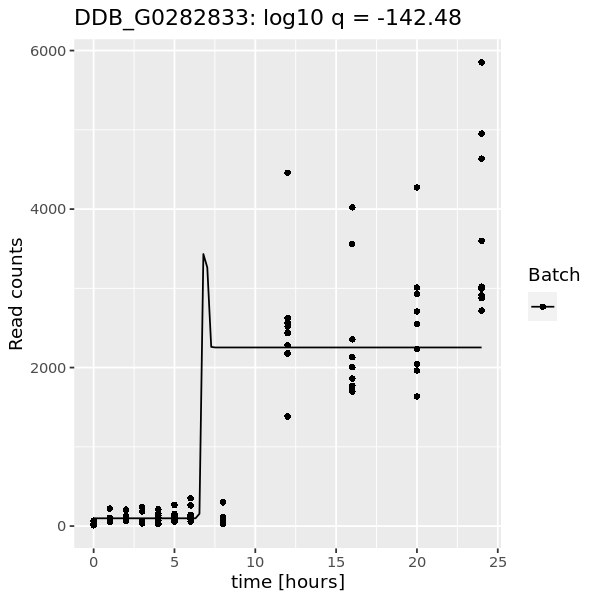

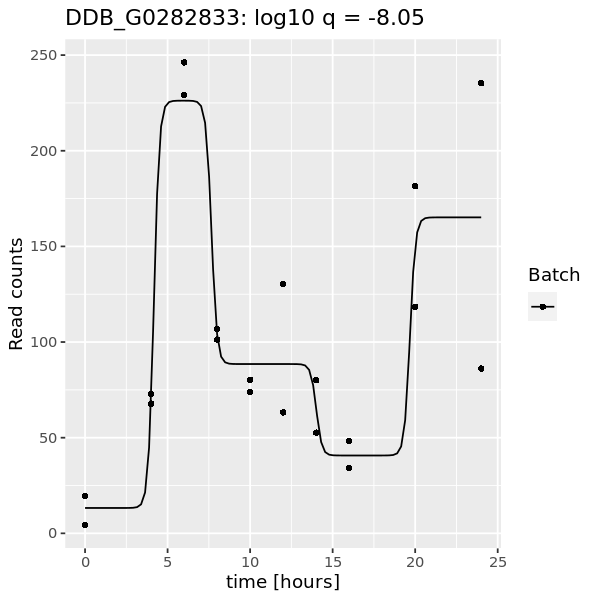

In [1123]:
idx=which(vecPlotGenes=='DDB_G0282833')
#print(fits_WT[vecPlotGenes[idx],])
#print(fits_gbfA[vecPlotGenes[idx],])
#findTransitions(impulse_WT,fits_WT[vecPlotGenes[idx],'bestFit'],vecPlotGenes[idx])
#findTransitions(impulse_gbfA,fits_gbfA[vecPlotGenes[idx],'bestFit'],vecPlotGenes[idx])
#res[vecPlotGenes[idx],]
plots_WT[[idx]]
plots_gbfA[[idx]]

[1] "Setting boolSimplePlot=TRUE as no batch structure was found."


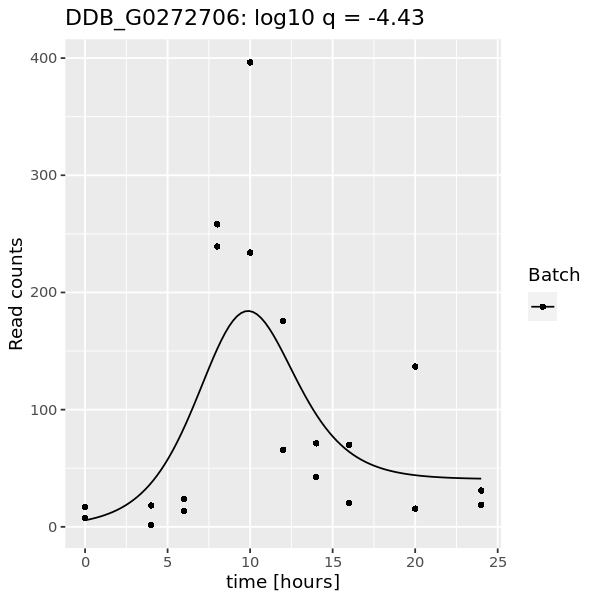

In [942]:
plotGenesExtended(
vecGeneIDs = c('DDB_G0272706'),
scaNTopIDs = NULL,
objectImpulseDE2 = impulse_gbfA,
boolCaseCtrl = FALSE,
dirOut = NULL,
strFileName = NULL,
vecRefPval = NULL,
strNameRefMethod = NULL,model='impulse')[[1]]

In [872]:
plots_WT<-plotGenesExtended(
vecGeneIDs = vecPlotGenes,
scaNTopIDs = NULL,
objectImpulseDE2 = impulse_WT,
boolCaseCtrl = FALSE,
dirOut = NULL,
strFileName = NULL,
vecRefPval = NULL,
strNameRefMethod = NULL,model='fourSigmoid')
plots_gbfA<-plotGenesExtended(
vecGeneIDs = vecPlotGenes,
scaNTopIDs = NULL,
objectImpulseDE2 = impulse_gbfA,
boolCaseCtrl = FALSE,
dirOut = NULL,
strFileName = NULL,
vecRefPval = NULL,
strNameRefMethod = NULL,model='fourSigmoid')

[1] "Setting boolSimplePlot=TRUE as no batch structure was found."
[1] "Setting boolSimplePlot=TRUE as no batch structure was found."


In [284]:
unlist(as.vector((df[1,])))

S1    S2    S3    S4 
FALSE FALSE FALSE FALSE

In [256]:
sum(result$isMonotonous)

[1] 8898

In [265]:
sum(boolFourSigmoid)

[1] 40

In [254]:
sum((result$padj<=scaQThres & result$impulseTOsigmoid_padj<=scaQThres & result$NMinMax_impulse ==3))

[1] 791

In [228]:
sum((result$fourSigmoidTOconst_padj<=scaQThres & 
                      result$fourSigmoidTOsigmoid_padj<=scaQThres &
                      result$fourSigmoidTOimpulse_padj<=scaQThres &
                      result$fourSigmoidTOthreeSigmoid_padj<=scaQThres &
                      result$NMinMax_fourSigmoid == 5))

[1] 40

In [223]:
colnames(r)

[1] "Gene"                           "p"                             
 [3] "padj"                           "loglik_full"                   
 [5] "loglik_red"                     "df_full"                       
 [7] "df_red"                         "mean"                          
 [9] "converge_impulse"               "converge_const"                
[11] "converge_sigmoid"               "impulseTOsigmoid_p"            
[13] "impulseTOsigmoid_padj"          "sigmoidTOconst_p"              
[15] "sigmoidTOconst_padj"            "isTransient"                   
[17] "isMonotonous"                   "converge_threeSigmoid"         
[19] "converge_fourSigmoid"           "threeSigmoidTOconst_p"         
[21] "threeSigmoidTOconst_padj"       "threeSigmoidTOsigmoid_p"       
[23] "threeSigmoidTOsigmoid_padj"     "threeSigmoidTOimpulse_p"       
[25] "threeSigmoidTOimpulse_padj"     "fourSigmoidTOconst_p"          
[27] "fourSigmoidTOconst_padj"        "fourSigmoidTOsigmoid_p"        
[29] "fourSigmoidTOsigmoid_padj"      "fourSigmoidTOimpulse_p"        
[31] "fourSigmoidTOimpulse_padj"      "fourSigmoidTOthreeSigmoid_p"   
[33] "fourSigmoidTOthreeSigmoid_padj" "NMinMax_impulse"               
[35] "NMinMax_threeSigmoid"           "NMinMax_fourSigmoid"           
[37] "allZero"

In [506]:
library(ComplexHeatmap)
library(circlize)
library(viridis)
library(proxy)
library(seriation)
library(dendextend)
library(dplyr)

In [476]:
path_expression='/home/khrovatin/timeTrajectoriesNet/data/regulons/'
path_strain_order='/home/khrovatin/timeTrajectoriesNet/data/'
path_phenotypes = '/home/khrovatin/timeTrajectoriesNet/data/stages/'

In [477]:
#**! Specify file names for regulons and expression
#** Expression tab file: Genes in columns (already scaled), averaged strain data in rows, 
#** three additional comlumns: Time, Strain, and Group (meaning strain group)
avg_expression=read.table(paste(path_expression,"genes_averaged_orange_scale99percentileMax0.1.tsv",sep=''),
                          header=TRUE,row.names=1, sep="\t")

#**! Specify file names for phenotipic data
#** Phenotypes tab file: Short averaged sample names in rows (as in avg_expression) and columns with phenotypes.
#** Phenotypes should have values: yes, no, no data
avg_phenotype=read.table(paste(path_phenotypes,"averageStages.tsv",sep=''),
                          header=TRUE,row.names=1, sep="\t", stringsAsFactors=FALSE)
#Change avg_phenotypes data so that each phenotype can be coloured differently
avg_phenotype[avg_phenotype=='no']=NA
for(col in colnames(avg_phenotype)){
  new_col=avg_phenotype[col]
  new_col[new_col=='yes']=col
  avg_phenotype[col]=new_col
}


#** Strain order - single column with ordered strain names
strain_order<-as.vector(read.table(paste(path_strain_order,"strain_order.tsv",sep=''))[,1])

In [478]:
#** Some plotting parameters
legend_font=12
phenotypes_font=10
legened_height=1.5
legend_width=0.7
top_annotation_height=0.6
phenotype_annotation_height=3
cluster_font=20

In [491]:
make_anno<-function(){



#Strain groups annotation
#** Colours of strain groups
group_cols=c('agg-'= '#ed1c24', 'lag_dis'= '#f97402','tag_dis'='#ffb100', 'tag'='#d9d800', 'cud'= '#008629', 'WT'= '#00b2ff',
                        'sFB'= '#1925ae', 'prec'='#a400d4' )
#group_cols_background=c('agg-'= '#cccccc', 'lag_dis'= '#666666','tag_dis'='#666666', 'tag'='#666666', 'cud'= '#cccccc', 
#                        'WT'= '#cccccc','sFB'= '#cccccc', 'prec'='#cccccc' )
group_cols_background=c('agg-'= 'white', 'lag_dis'= 'white','tag_dis'='#666666', 'tag'='#666666', 'cud'= 'white', 
                        'WT'= 'white','sFB'= 'white', 'prec'='white' )
group_cols_text=c('agg-'= 'black', 'lag_dis'= 'black','tag_dis'='black', 'tag'='black', 'cud'= '#eeeeee', 
                        'WT'= 'black','sFB'= '#eeeeee', 'prec'='#eeeeee' )

group_data=t(avg_expression['Group'])
rownames(group_data)<-c('Phenotypic group')            
# ht_list=Heatmap(group_data,show_column_names = FALSE, 
#                 height = unit(top_annotation_height, "cm"),
#                 column_split=factor(avg_expression$Strain,
#                                     #** Ordering of the strains in the heatmap (a vector of strain names)
#                                     #levels=unique(avg_expression$Strain)
#                                     levels=strain_order
#                 ),
#                 cluster_columns=FALSE,name='\nPhenotypic \ngroup\n',
#                 #** Strain name font size
#                 column_title_gp=gpar(fontsize=legend_font),
#                 col=group_cols, heatmap_legend_param = list( 
#                 grid_width= unit(legend_width, "cm"),grid_height= unit(legened_height, "cm") ,
#                 labels_gp = gpar(fontsize = cluster_font),title_gp = gpar(fontsize = cluster_font)),
#                 row_names_gp = gpar(fontsize = cluster_font))

#Time annotation
times=unique(avg_expression$Time)
#** Time colours, group colours, and gaps
group_cols_ordered=c()
groups_ordered=c()
background_cols_ordered=c()
text_cols_ordered=c()
gaps=c()
previous_group=NULL
for(strain in strain_order){
  group=as.character(avg_expression[avg_expression$Strain==strain,'Group'][1])
  #print(paste(strain,group,group_cols[group]))
  groups_ordered<-append(groups_ordered,group)
  group_cols_ordered<-append(group_cols_ordered,group_cols[group])
  background_cols_ordered<-append(background_cols_ordered,group_cols_background[group])
  text_cols_ordered<-append(text_cols_ordered,group_cols_text[group])
  #Gaps - if previous group was different add larger gap; (N gaps = N-1 columns)
  if (!is.null(previous_group)){
    if (previous_group==group){ 
      gaps=append(gaps,1)
    }else{
      gaps=append(gaps,2.5)
    }
  }
  previous_group=group
}
gaps=unit(gaps,'mm')

col_time = colorRamp2( c(min(times),max(times)),c( "white", "#440154FF"))

ht_list=Heatmap(t(avg_expression['Time']), height = unit(top_annotation_height, "cm"),
                column_split=factor(avg_expression$Strain,
                #** Ordering of the strains in the heatmap (a vector of strain names)
                levels=strain_order ),
                column_title =NULL,column_gap=gaps,
                cluster_columns=FALSE, show_column_names = FALSE,name='\nTime\n',col=col_time,
                heatmap_legend_param = 
                list( at = c(min(times),as.integer(mean(c(min(times),max(times)))),max(times)),
                grid_width= unit(legend_width, "cm"),grid_height= unit(legened_height, "cm") ,
                labels_gp = gpar(fontsize = cluster_font),title_gp = gpar(fontsize = cluster_font)
                    ),
                row_names_gp = gpar(fontsize = cluster_font),
                #column_title_gp=gpar(border =group_cols_ordered,fontsize=cluster_font,col =text_cols_ordered,fill=group_cols_ordered,
                #                     fontface='bold'),
                #Annotation for Phenotype group
                top_annotation = HeatmapAnnotation(
                  Phenotype=anno_block(gp = 
                                         # Background colour; fill: color, col: border                               
                                         #gpar(fill = '#949494',col='transparent'),
                                         #gpar(fill = 'white',col='transparent'),
                                         #gpar(fill = background_cols_ordered,col='transparent'),
                                         #gpar(fill = group_cols_ordered,col=group_cols_ordered),
                                         gpar(fill=group_cols_ordered,col=group_cols_ordered,lwd =2,linejoin='mitre'),
                                       labels = groups_ordered , labels_gp = gpar(col = 
                                                                                    # Text colour
                                                                                    # 'black',
                                                                                    #group_cols_ordered, 
                                                                                    text_cols_ordered,
                                                                                  fontsize = cluster_font
                                                                                  #,fontface='bold'
                                       ),
                                       #show_name = TRUE
                                      ) ,
                  Strain = anno_block(gp = 
                                            # Background colour; fill: color, col: border                               
                                            #gpar(fill = '#949494',col='transparent'),
                                            #gpar(fill = 'white',col='transparent'),
                                            #gpar(fill = background_cols_ordered,col='transparent'),
                                            #gpar(fill = group_cols_ordered,col=group_cols_ordered),
                                              gpar(fill='white',col=group_cols_ordered,lwd =2,linejoin='mitre'),
                        labels = strain_order , labels_gp = gpar(col = 
                                                                    # Text colour
                                                                   'black',
                                                                    #group_cols_ordered, 
                                                                    #text_cols_ordered,
                                                                    fontsize = cluster_font
                                                                  #,fontface='bold'
                                                                  ), 
                                      #show_name = TRUE
                                     ),
                annotation_name_gp=gpar(fontsize = cluster_font)
                        )
                )
#ht_list=ht_list %v% ht_time

#Phenotype annotation
#** Colours of phenotype annotations
phenotype_cols=c('no image'= '#d9d9d9', 'no_agg'= '#ed1c24', 'stream'= '#985006', 'lag'= '#f97402', 'tag'= '#d9d800', 'tip'= '#66cf00',
  'slug'= '#008629', 'mhat'= '#00c58f', 'cul'= '#0ff2ff', 'FB'= '#00b2ff', 'yem'='#666666')
#phenotype_cols=c('no data'= '#d9d9d9', 'yes'= '#74cf19', 'no'='#b54c4c')
ht_phenotype=Heatmap(t(avg_phenotype)[,rownames(avg_expression)], height = unit(phenotype_annotation_height, "cm"),
                cluster_columns=FALSE,cluster_rows=FALSE, show_column_names = FALSE,name='\nMorphological \nstage\n',col=phenotype_cols,
                row_names_gp = gpar(fontsize = phenotypes_font), na_col = "white",
                row_title ='Morphological stage',row_title_side ='right',row_title_gp=gpar(fontsize = cluster_font),
                heatmap_legend_param = list( grid_width= unit(legend_width, "cm"),grid_height= unit(legened_height, "cm") ,
                                             labels_gp = gpar(fontsize = cluster_font),title_gp = gpar(fontsize = cluster_font)))
ht_list=ht_list %v% ht_phenotype
    
return(ht_list)
}

In [482]:
stage_order<-colnames(avg_phenotype)
expressions<-within(avg_expression, rm('Time', 'Strain','Group'))
min_expression<-min(expressions)
max_expression<-max(expressions)

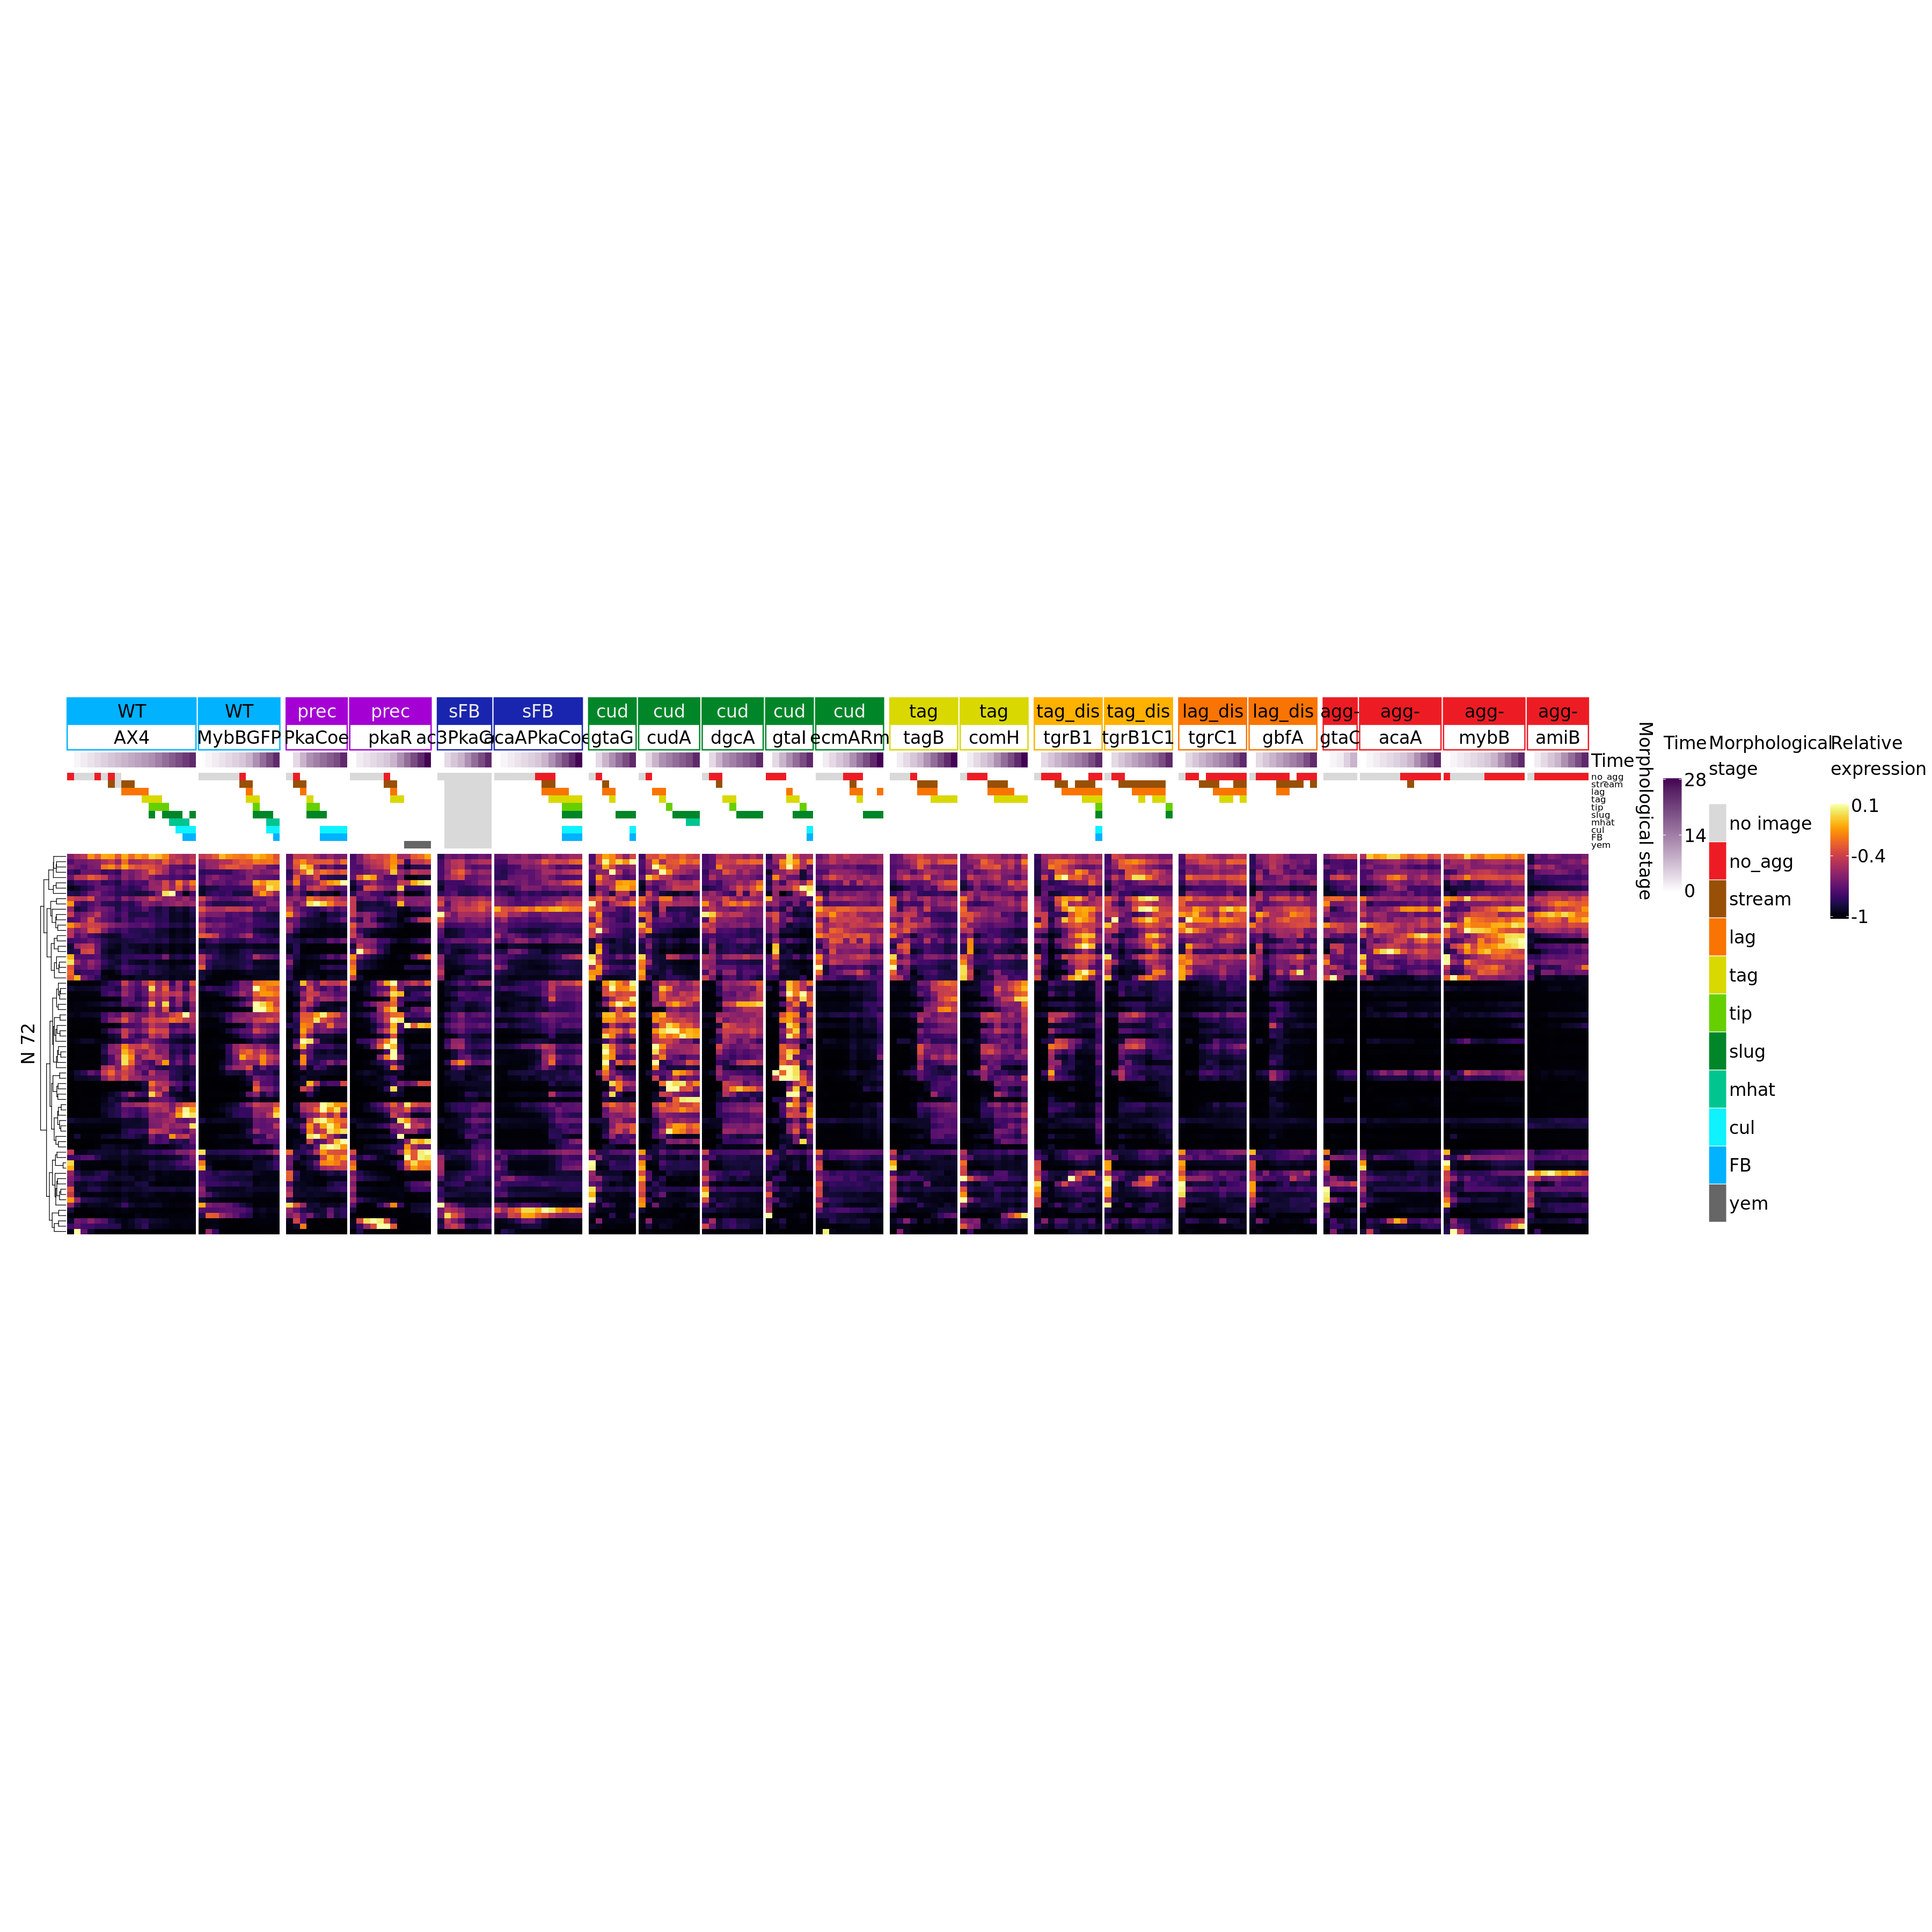

In [1122]:
options(repr.plot.width=30, repr.plot.height=30)
genes<-intersect(vecPlotGenes,rownames(res)[res$selected])
    
    expression=t(avg_expression[avg_expression$Strain=='AX4',genes])
    #expression=t(avg_expression[,genes])
    distances<-dist(expression, method="cosine")
    hc<-hclust(d=distances, method = "ward.D2" )
    hc_ordered<-reorder(x=hc,dist = distances)
    genes<- as.dendrogram(hc_ordered) %>% labels
    
    n_genes=length(genes)
    #print(paste(comparison,n_genes))

    data_anno=paste('N',n_genes)
    height=0.3*n_genes
    if (height>15) height=15
    heatmap=Heatmap(t(avg_expression[,genes]),
                    cluster_columns = FALSE,cluster_rows = TRUE,
                    show_column_names = FALSE,
                      show_row_names = FALSE, col=inferno(256),column_title=NULL, 
                      row_title=data_anno,
                      show_heatmap_legend = TRUE,heatmap_legend_param = list(
                      title = "\nRelative \nexpression\n",
                      at = c(min_expression, round(mean(c(min_expression,max_expression)),1),max_expression),
                      grid_width= unit(legend_width, "cm"),grid_height= unit(legened_height, "cm") ,
                      labels_gp = gpar(fontsize = cluster_font),title_gp = gpar(fontsize = cluster_font)),
                      #** Cluster name fontsize
                      row_title_gp=gpar(fontsize=cluster_font),height=unit(height, "cm"))

    draw(make_anno() %v% heatmap,width=unit(60, "cm"),column_title_gp = gpar(fontsize = cluster_font))
options(repr.plot.width=5, repr.plot.height=5)

In [1121]:
write.table(data.frame(Gene=intersect(vecPlotGenes,rownames(res)[!res$selected])),file=paste(pathSave,'try3.tsv',sep=''),sep='\t',row.names = FALSE)